<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Italy" data-toc-modified-id="Italy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Italy</a></span></li><li><span><a href="#GB" data-toc-modified-id="GB-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GB</a></span></li><li><span><a href="#US" data-toc-modified-id="US-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>US</a></span></li><li><span><a href="#Spain" data-toc-modified-id="Spain-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Spain</a></span></li><li><span><a href="#Germany" data-toc-modified-id="Germany-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Germany</a></span></li><li><span><a href="#France" data-toc-modified-id="France-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>France</a></span></li></ul></div>

## Overview
For the countries that flattened their curve and are past their peak, its clear the daily case distributions are skewed - they are steep on the way up, and much less steep on the way down. I think I can fit this better with a gamma function. This notebook explores that, and fits against countries close to, or past their peak.

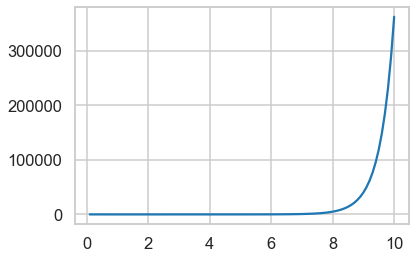

In [1]:
import numpy as np
import pandas as pd
from math import gamma
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

x = np.linspace(0.1,10,100)
y = [gamma(x) for x in x]

plt.plot(x,y)
plt.show()

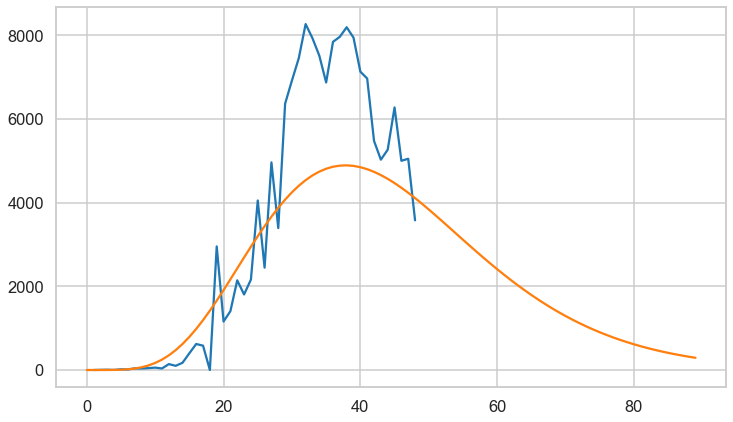

In [2]:
def gamma_pdf(x, k=10, theta=0.5, spread=20):
    alpha = k
    beta = 1/theta
    denom = gamma(alpha)
    numer = 1
    numer *= beta**alpha
    numer *= x**(alpha-1)
    numer *= np.exp(-1*beta*x)
    return numer/denom

peak=200000
duration=90

spread=20
theta=1.5
k=spread/(2*theta)
nearly_zero = 0.1**100
x = np.linspace(nearly_zero, spread, duration)
case_scale = peak*spread/duration
y = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x]


fig, ax = plt.subplots(1,1,figsize=(12,7))
es_df = pd.read_csv('../data/raw/es_df.csv')
es_df['Actual'].dropna().diff().plot()
ax.plot(y)
plt.show()

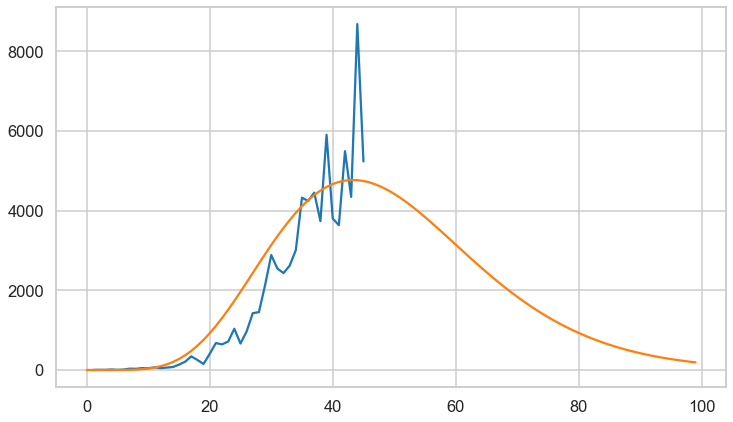

In [3]:
peak=200000
duration=100

spread=16
theta=1
k=spread/(2*theta)
nearly_zero = 0.1**100
x = np.linspace(nearly_zero, spread, duration)[:]
case_scale = peak*spread/duration
y = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x]


fig, ax = plt.subplots(1,1,figsize=(12,7))
gb_df = pd.read_csv('../data/raw/gb_df.csv')
gb_df['Actual'].diff().dropna().plot()
ax.plot(y)
plt.show()

## Italy

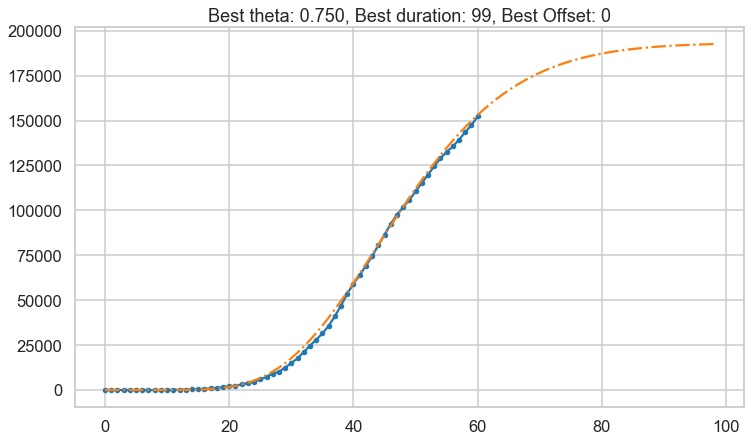

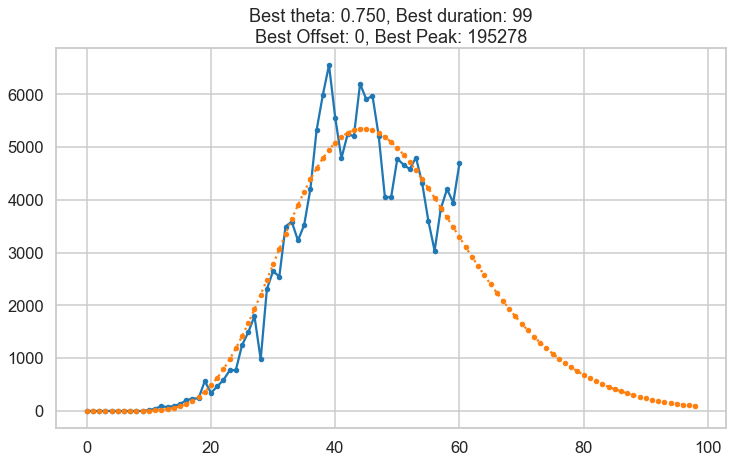

In [11]:
# Load country data
it_df = pd.read_csv('../data/raw/it_df.csv')
y = it_df['Actual'].diff().dropna().values.tolist()

def rmse(residual):
    mse = [x**2 for x in residual]
    rmse = (sum(mse)/len(residual))**0.5
    return rmse

peak_guess=185000
duration_guess=100
spread=16
nearly_zero = 0.1**100

score_lst = []
day_offset = 5
for day in range(day_offset):
    for peak in np.linspace(peak_guess*0.5, peak_guess*1.5, 10):
        for duration in range(duration_guess-3, duration_guess+4):
            d_int = int(duration)
            x = np.linspace(nearly_zero, spread, d_int)
            case_scale = peak*spread/d_int
            for theta in np.linspace(0.25, 1.75, 10):
                k=spread/(2*theta)
                y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][day:]
                residual = [x-y for x, y in zip(y, y_pred)]
                score = rmse(residual)
                df = pd.DataFrame({'theta': [theta],
                                   'duration': [d_int],
                                   'peak': [peak],
                                   'day_offset': [day],
                                   'score': [score]})
                score_lst.append(df)

score_df = pd.concat(score_lst).set_index(['theta', 'duration', 'peak', 'day_offset'])
best_theta, best_duration, best_peak, best_day_offset = score_df.idxmin().values[0]

theta = best_theta
k = spread/(2*theta)
case_scale = best_peak * spread/best_duration
x = np.linspace(nearly_zero, spread, best_duration)
y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][best_day_offset:]

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(np.cumsum(y), marker='.')
ax.plot(np.cumsum(y_pred), linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(y, marker='.')
ax.plot(y_pred, marker='.', linestyle=':')
title_str = f'Best theta: {best_theta:.3f}, Best duration: {best_duration}\n'
title_str += f'Best Offset: {best_day_offset}, Best Peak: {best_peak:.0f}'
plt.title(title_str)
plt.show()

## GB

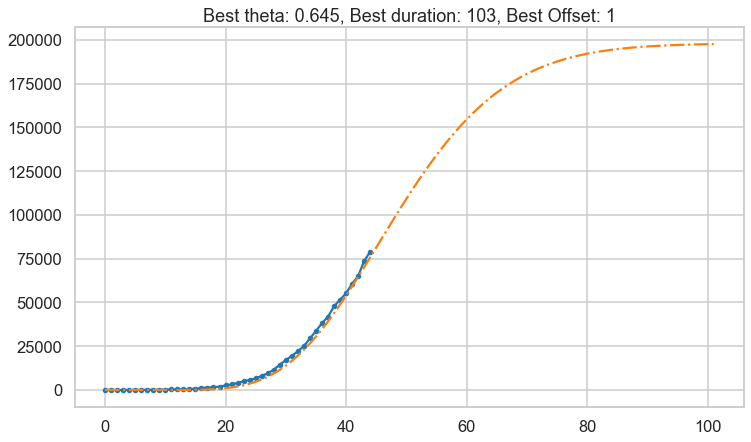

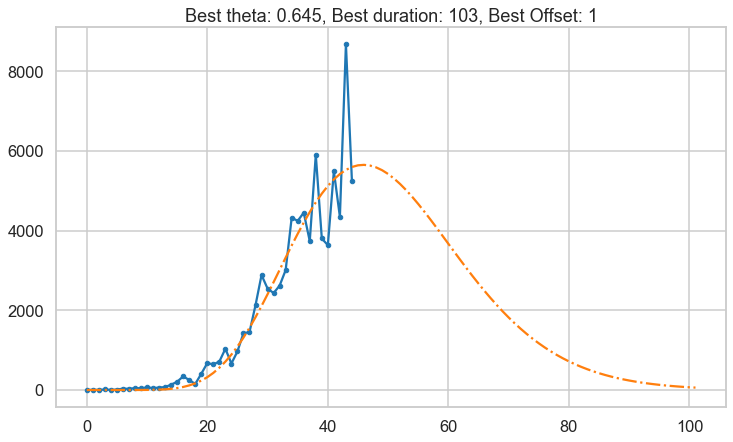

In [5]:
# Load country data
gb_df = pd.read_csv('../data/raw/gb_df.csv')
y = gb_df['Actual'].diff().dropna().values.tolist()

def rmse(residual):
    mse = [x**2 for x in residual]
    rmse = (sum(mse)/len(residual))**0.5
    return rmse

peak_guess=200000
duration_guess=100
spread=16
nearly_zero = 0.1**100

score_lst = []
day_offset = 20
for day in range(day_offset):
    for duration in range(duration_guess-3, duration_guess+4):
        d_int = int(duration)
        x = np.linspace(nearly_zero, spread, d_int)
        case_scale = peak_guess*spread/d_int
        for theta in np.linspace(0.25, 1.75, 20):
            k=spread/(2*theta)
            y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][day:]
            residual = [x-y for x, y in zip(y, y_pred)]
            score = rmse(residual)
            df = pd.DataFrame({'theta': [theta],
                               'duration': [d_int],
                               'day_offset': [day],
                               'score': [score]})
            score_lst.append(df)

score_df = pd.concat(score_lst).set_index(['theta', 'duration', 'day_offset'])
best_theta, best_duration, best_day_offset = score_df.idxmin().values[0]

theta=best_theta
k=spread/(2*theta)
x = np.linspace(nearly_zero, spread, best_duration)
y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][best_day_offset:]

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(np.cumsum(y), marker='.')
ax.plot(np.cumsum(y_pred), linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(y, marker='.')
ax.plot(y_pred, linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

## US

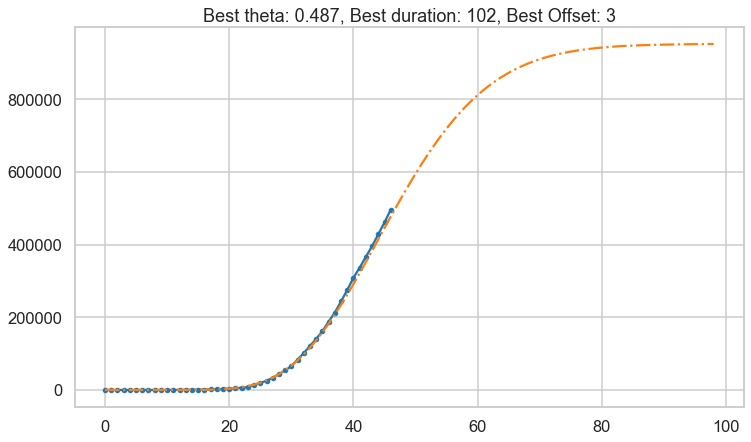

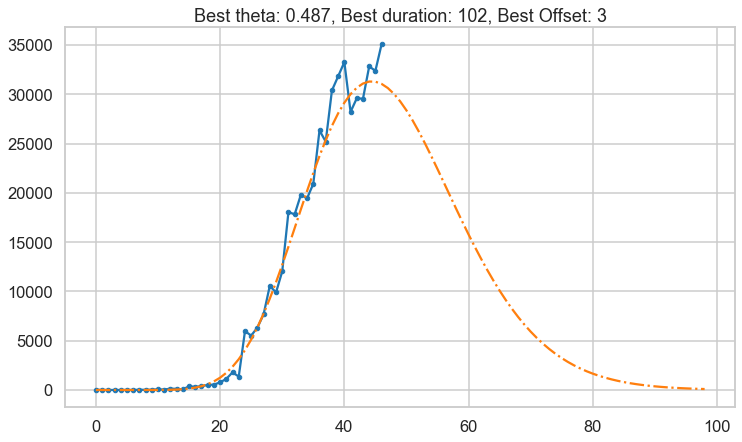

In [12]:
# Load country data
us_df = pd.read_csv('../data/raw/us_df.csv')
y = us_df['Actual'].diff().dropna().values.tolist()

def rmse(residual):
    mse = [x**2 for x in residual]
    rmse = (sum(mse)/len(residual))**0.5
    return rmse

peak_guess=1000000
duration_guess=100
spread=16
nearly_zero = 0.1**100

score_lst = []
day_offset = 20
for day in range(day_offset):
    for duration in range(duration_guess-3, duration_guess+7):
        d_int = int(duration)
        x = np.linspace(nearly_zero, spread, d_int)
        case_scale = peak_guess*spread/d_int
        for theta in np.linspace(0.25, 1.75, 20):
            k=spread/(2*theta)
            y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][day:]
            residual = [x-y for x, y in zip(y, y_pred)]
            score = rmse(residual)
            df = pd.DataFrame({'theta': [theta],
                               'duration': [d_int],
                               'day_offset': [day],
                               'score': [score]})
            score_lst.append(df)

score_df = pd.concat(score_lst).set_index(['theta', 'duration', 'day_offset'])
best_theta, best_duration, best_day_offset = score_df.idxmin().values[0]

theta=best_theta
k=spread/(2*theta)
x = np.linspace(nearly_zero, spread, best_duration)
y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][best_day_offset:]

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(np.cumsum(y), marker='.')
ax.plot(np.cumsum(y_pred), linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(y, marker='.')
ax.plot(y_pred, linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

## Spain

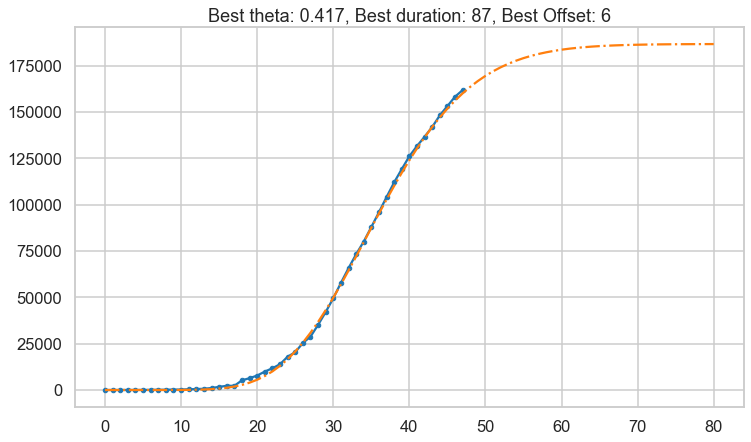

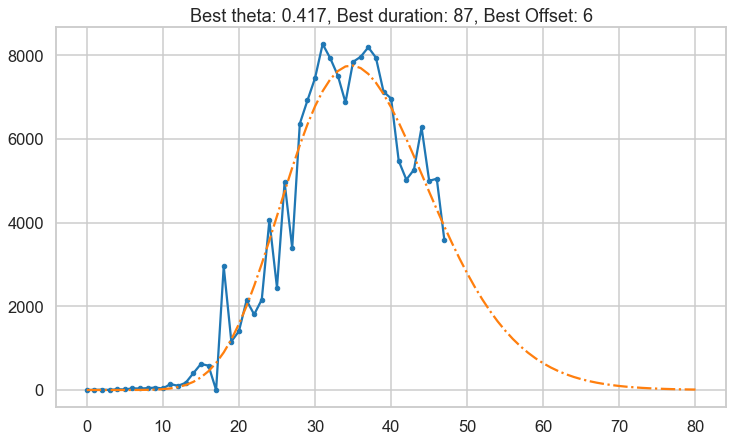

In [13]:
# Load country data
es_df = pd.read_csv('../data/raw/es_df.csv')
y = es_df['Actual'].diff().dropna().values.tolist()

def rmse(residual):
    mse = [x**2 for x in residual]
    rmse = (sum(mse)/len(residual))**0.5
    return rmse

peak_guess=200000
duration_guess=90
spread=16
nearly_zero = 0.1**100

score_lst = []
day_offset = 10
for peak in np.linspace(peak_guess*0.5, peak_guess*1.5, 10):
    for day in range(day_offset):
        for duration in range(duration_guess-3, duration_guess+7):
            d_int = int(duration)
            x = np.linspace(nearly_zero, spread, d_int)
            case_scale = peak*spread/d_int
            for theta in np.linspace(0.25, 1.75, 10):
                k=spread/(2*theta)
                y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][day:]
                residual = [x-y for x, y in zip(y, y_pred)]
                score = rmse(residual)
                df = pd.DataFrame({'theta': [theta],
                                   'duration': [d_int],
                                   'peak': [peak],
                                   'day_offset': [day],
                                   'score': [score]})
                score_lst.append(df)

score_df = pd.concat(score_lst).set_index(['theta', 'duration', 'peak', 'day_offset'])
best_theta, best_duration, best_peak, best_day_offset = score_df.idxmin().values[0]

theta=best_theta
k=spread/(2*theta)
case_scale = best_peak*spread/best_duration
x = np.linspace(nearly_zero, spread, best_duration)
y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][best_day_offset:]

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(np.cumsum(y), marker='.')
ax.plot(np.cumsum(y_pred), linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(y, marker='.')
ax.plot(y_pred, linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

## Germany

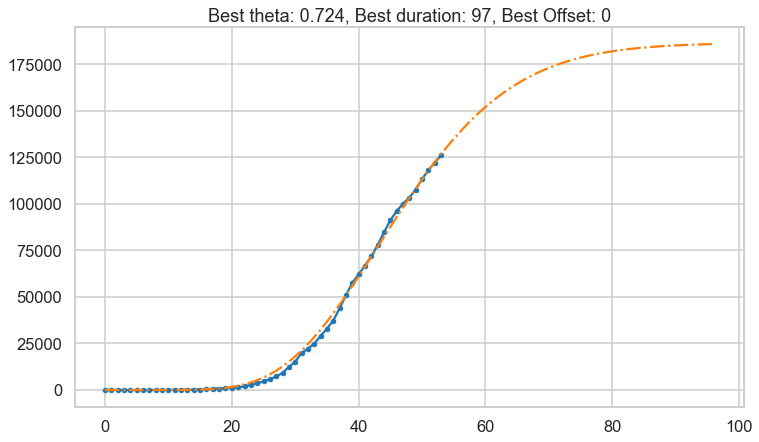

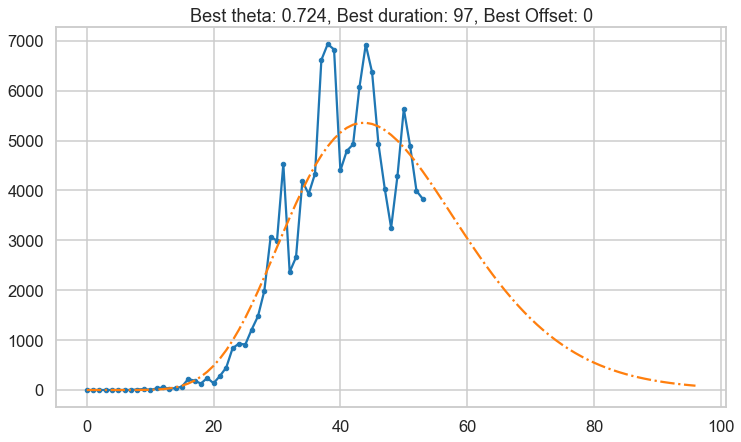

In [19]:
# Load country data
de_df = pd.read_csv('../data/raw/de_df.csv')
y = de_df['Actual'].diff().dropna().values.tolist()

def rmse(residual):
    mse = [x**2 for x in residual]
    rmse = (sum(mse)/len(residual))**0.5
    return rmse

peak_guess=200000
duration_guess=100
spread=16
nearly_zero = 0.1**100

score_lst = []
day_offset = 20
for day in range(day_offset):
    for duration in range(duration_guess-3, duration_guess+4):
        d_int = int(duration)
        x = np.linspace(nearly_zero, spread, d_int)
        case_scale = peak_guess*spread/d_int
        for theta in np.linspace(0.25, 1.75, 20):
            k=spread/(2*theta)
            y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][day:]
            residual = [x-y for x, y in zip(y, y_pred)]
            score = rmse(residual)
            df = pd.DataFrame({'theta': [theta],
                               'duration': [d_int],
                               'day_offset': [day],
                               'score': [score]})
            score_lst.append(df)

score_df = pd.concat(score_lst).set_index(['theta', 'duration', 'day_offset'])
best_theta, best_duration, best_day_offset = score_df.idxmin().values[0]

theta=best_theta
k=spread/(2*theta)
x = np.linspace(nearly_zero, spread, best_duration)
y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][best_day_offset:]

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(np.cumsum(y), marker='.')
ax.plot(np.cumsum(y_pred), linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(y, marker='.')
ax.plot(y_pred, linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

## France

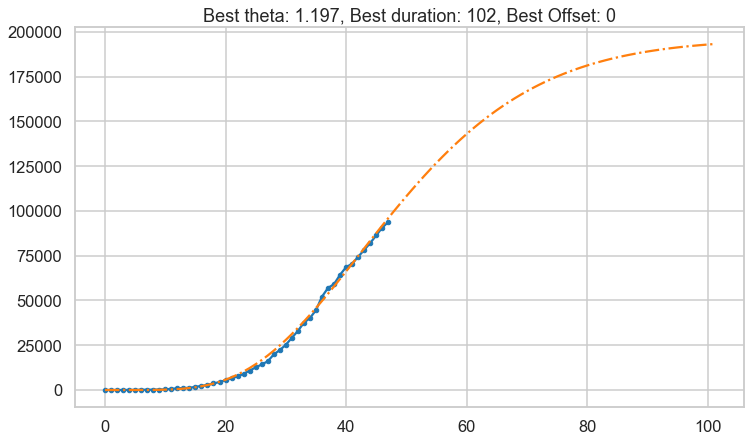

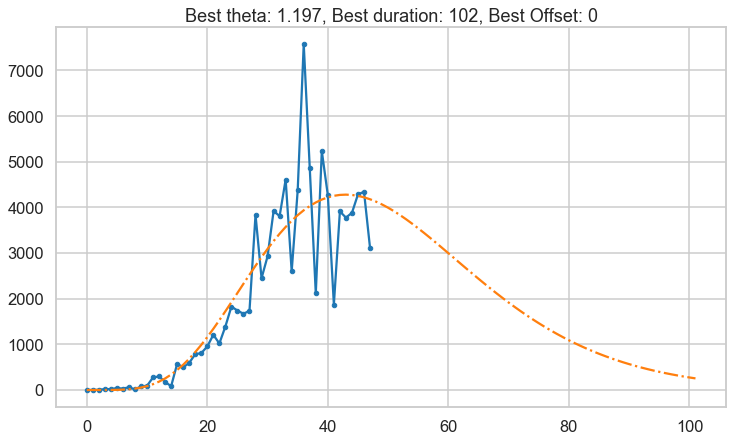

In [10]:
# Load country data
fr_df = pd.read_csv('../data/raw/fr_df.csv')
y = fr_df['Actual'].diff().dropna().values.tolist()

def rmse(residual):
    mse = [x**2 for x in residual]
    rmse = (sum(mse)/len(residual))**0.5
    return rmse

peak_guess=200000
duration_guess=100
spread=16
nearly_zero = 0.1**100

score_lst = []
day_offset = 20
for day in range(day_offset):
    for duration in range(duration_guess-3, duration_guess+4):
        d_int = int(duration)
        x = np.linspace(nearly_zero, spread, d_int)
        case_scale = peak_guess*spread/d_int
        for theta in np.linspace(0.25, 1.75, 20):
            k=spread/(2*theta)
            y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][day:]
            residual = [x-y for x, y in zip(y, y_pred)]
            score = rmse(residual)
            df = pd.DataFrame({'theta': [theta],
                               'duration': [d_int],
                               'day_offset': [day],
                               'score': [score]})
            score_lst.append(df)

score_df = pd.concat(score_lst).set_index(['theta', 'duration', 'day_offset'])
best_theta, best_duration, best_day_offset = score_df.idxmin().values[0]

theta=best_theta
k=spread/(2*theta)
x = np.linspace(nearly_zero, spread, best_duration)
y_pred = [gamma_pdf(x, k=k, theta=theta, spread=spread)*case_scale for x in x][best_day_offset:]

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(np.cumsum(y), marker='.')
ax.plot(np.cumsum(y_pred), linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(y, marker='.')
ax.plot(y_pred, linestyle='-.')
plt.title(f'Best theta: {best_theta:.3f}, Best duration: {best_duration}, Best Offset: {best_day_offset}')
plt.show()